# ACS2 vs ACS2ER in Multiplexer

In [16]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from lcs.metrics import population_metrics
from lcs.agents.EnvironmentAdapter import EnvironmentAdapter

import gym
import gym_multiplexer
from gym_multiplexer.utils import get_correct_answer
from lcs import Perception

from lcs.agents.acs2 import ACS2, Configuration as CFG_ACS2
from lcs.agents.acs2er import ACS2ER, Configuration as CFG_ACS2ER


# EXPERIMENT CONFIGURATION

In [17]:
CART_POLE = "CartPole-v1" 

EXPLORE_TRIALS = 1000
EXPLOIT_TRIALS = 100

# The size of ER replay memory buffer
ER_BUFFER_SIZE=1000
# The minimum number of samples of ER replay memory buffer to start replying samples (warm-up phase)
ER_BUFFER_MIN_SAMPLES=100
# The number of samples to be replayed druing ER phase
ER_SAMPLES_NUMBER=3


In [3]:
# env = gym.make('CartPole-v0')

# obs_adj_trials=20_000
# bins = 6


In [4]:
# %%time
# print(f'Performing {obs_adj_trials} trials with random steps to collect ranges for observation points')

# obs_arr = np.zeros((obs_adj_trials, 4))

# for i in range(obs_adj_trials):
#     env.reset()
#     done = False
#     while not done:
#         obs, reward, done, _ = env.step(env.action_space.sample())
#         obs_arr[i, :] = obs

# env.close()

# _high = obs_arr.max(axis=0)
# _low = obs_arr.min(axis=0)

# _range = _high - _low
# _range

Performing 20000 trials with random steps to collect ranges for observation points
Wall time: 6.92 s


array([4.30162177, 6.6443159 , 0.54319009, 7.12160883])

## Metrics and helpers

In [18]:
import math
# https://medium.com/@tuzzer/cart-pole-balancing-with-q-learning-b54c6068d947

env = gym.make(CART_POLE)

_high = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
_low = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]

# working (1, 1, 10, 14)
buckets = (1, 1, 6, 6)

class CartPoleObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

    def observation(self, obs):
        ratios = [(obs[i] + abs(_low[i])) / (_high[i] - _low[i]) for i in range(len(obs))]
        new_obs = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
        new_obs = [min(buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
        return [str(o) for o in new_obs]

def avg_fitness(pop):
    return np.mean([cl.fitness for cl in pop if cl.is_reliable()])


# collect more metrics
def cp_metrics(agent, env):
    metrics = {}
    metrics['avg_fitness'] = avg_fitness(agent.population)
    metrics.update(population_metrics(agent.population, env))

    return metrics


### Results arrays

ACS2 Experiments

In [19]:

### ACS2 ###
# Load desired environment
env = gym.make(CART_POLE)
cp = CartPoleObservationWrapper(env)
# Create agent 
cfg_acs2 = CFG_ACS2(
            classifier_length=4,
            number_of_possible_actions=2,
            epsilon=0.95,
            biased_exploration=0.5,
            beta=0.05,
            gamma=0.99,
            theta_exp=50,
            theta_ga=50,
            do_ga=False,
            mu=0.03,
            u_max=4,
            metrics_trial_frequency=1,
            user_metrics_collector_fcn=cp_metrics)
agent_acs2 = ACS2(cfg_acs2)
# Explore the environment
acs2_explore_metrics = agent_acs2.explore(cp, EXPLORE_TRIALS)
# Exploit the environment
acs2_exploit_metrics = agent_acs2.exploit(cp, EXPLOIT_TRIALS)


E:\_ZSSE\Anaconda\envs\pyalcs-experiments-acs2er\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
E:\_ZSSE\Anaconda\envs\pyalcs-experiments-acs2er\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ACS2ER Experiments

In [20]:

### ACS2ER ###
# Load desired environment
env = gym.make(CART_POLE)
cp = CartPoleObservationWrapper(env)
# Create agent ACS2ER
cfg_acs2er = CFG_ACS2ER(
            classifier_length=4,
            number_of_possible_actions=2,
            epsilon=0.95,
            biased_exploration=0.05,
            beta=0.05,
            gamma=0.99,
            theta_exp=50,
            theta_ga=50,
            do_ga=False,
            mu=0.03,
            u_max=4,
            metrics_trial_frequency=1,
            er_buffer_size=ER_BUFFER_SIZE,
            er_min_samples=ER_BUFFER_MIN_SAMPLES,
            er_samples_number=ER_SAMPLES_NUMBER,
            user_metrics_collector_fcn=cp_metrics)
agent_acs2er = ACS2ER(cfg_acs2er)
# Explore the environment
acs2er_explore_metrics = agent_acs2er.explore(cp, EXPLORE_TRIALS)
# Exploit the environment
acs2er_exploit_metrics = agent_acs2er.exploit(cp, EXPLOIT_TRIALS)

    

In [1]:
# x_axis = range(EXPERIMENTS)

# plt.title("Multiplexer - EXPLORE")
# plt.scatter(x_axis, acs2_explore_results, c='r', label="ACS2")
# plt.scatter(x_axis, acs2er_explore_results, c='b', label="ACS2ER")
# plt.legend()
# plt.xlabel("experiment")
# plt.ylabel("avg. reward")
# plt.show()
# # plt.savefig(f"EXPLORE_{RUN}.png")
# plt.close()

# plt.title("Multiplexer - EXPLOIT")
# plt.scatter(x_axis, acs2_exploit_results, c='r', label="ACS2")
# plt.scatter(x_axis, acs2er_exploit_results, c='b', label="ACS2ER")
# plt.xlabel("experiment")
# plt.ylabel("avg. reward")
# plt.legend()
# plt.show()
# # plt.savefig(f"EXPLOIT_{RUN}.png")

In [21]:
RELIABLE_KEY = "reliable"
STEPS_IN_TRIAL_KEY = 'steps_in_trial'

def extract_number_of_reliable_cl(metrics):
    return list(map(lambda m: m[RELIABLE_KEY], metrics))

def extract_steps_in_trials(metrics):
    return list(map(lambda m: m[STEPS_IN_TRIAL_KEY], metrics))

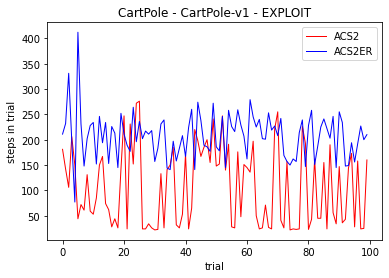

In [24]:
acs2_steps = extract_steps_in_trials(acs2_exploit_metrics)
acs2er_steps = extract_steps_in_trials(acs2er_exploit_metrics)

x_axis = range(len(acs2_steps))

plt.title(f"CartPole - {CART_POLE} - EXPLOIT")
plt.plot(x_axis, acs2_steps, c='r', label="ACS2", linewidth=1.0)
plt.plot(x_axis, acs2er_steps, c='b', label="ACS2ER", linewidth=1.0)
plt.legend()
plt.xlabel("trial")
plt.ylabel("steps in trial")
plt.show()
# plt.savefig(f"EXPLORE_{RUN}.png")


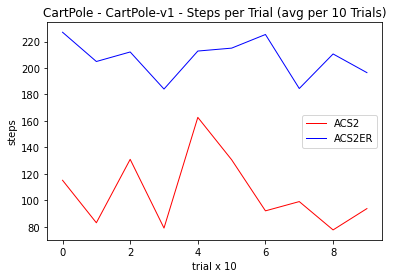

In [23]:
AVG_SIZE = 10


acs2_steps_chunks = np.reshape(np.array(acs2_steps), (-1, AVG_SIZE))
acs2_steps_avg = np.mean(acs2_steps_chunks, axis=1)
acs2er_steps_chunks = np.reshape(np.array(acs2er_steps), (-1, AVG_SIZE))
acs2er_steps_avg = np.mean(acs2er_steps_chunks, axis=1)
x_axis_avg = range(len(acs2_steps_avg))

plt.title(f"CartPole - {CART_POLE} - Steps per Trial (avg per {AVG_SIZE} Trials)")
plt.plot(x_axis_avg, acs2_steps_avg, c='r', label="ACS2", linewidth=1.0)
plt.plot(x_axis_avg, acs2er_steps_avg, c='b', label="ACS2ER", linewidth=1.0)
plt.legend()
plt.xlabel(f"trial x {AVG_SIZE}")
plt.ylabel("steps")
plt.show()